In [96]:
import librosa
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import seaborn as sns

In [97]:
n_mfcc = 40
n_fft = 1024  # setting the FFT size to 1024
hop_length = 10*16 # 25ms*16khz samples has been taken
win_length = 25*16 #25ms*16khz samples has been taken for window length
window = 'hann' #hann window used
n_chroma=12
n_mels=128
n_bands=7 #we are extracting the 7 features out of the spectral contrast
fmin=100
bins_per_ocatve=12

In [98]:
# define function to extract features
def extract_features(file_path):
    try:
        # Load audio file and extract features
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40,n_fft=n_fft,hop_length=hop_length,win_length=win_length,window=window).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann',n_mels=n_mels).T,axis=0)
        stft = np.abs(librosa.stft(y))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr,n_fft=n_fft,
                                                      hop_length=hop_length, win_length=win_length,
                                                      n_bands=n_bands, fmin=fmin).T,axis=0)
        tonnetz =np.mean(librosa.feature.tonnetz(y=y, sr=sr).T,axis=0)
        features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz))
        # print(shape(features))
        return features
    except:
        print("Error: Exception occurred in feature extraction")
        return None

# define path to data directory
path = '/home/pi/CryClassification/dataset' #Provide your path here
# initialize empty lists to hold extracted features and labels
features = []
labels = []

# loop through the directories
for label in os.listdir(path):
    # loop through the files in each directory
    print(f"{label} data is loading.....")
    for file_name in os.listdir(os.path.join(path, label)):
        file_path = os.path.join(path, label, file_name)
        # extract features and append to list
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(label)
    print(f"{label} data loaded....")

discomfort data is loading.....
discomfort data loaded....
burping data is loading.....
burping data loaded....
belly_pain data is loading.....
belly_pain data loaded....
tired data is loading.....
tired data loaded....
hungry data is loading.....
hungry data loaded....


In [99]:
df = pd.DataFrame({'label': labels, 'features': features}, columns=['label', 'features'])

In [100]:
df.head()

,label,features
0,discomfort,"[-602.546630859375, 91.33323669433594, -78.116..."
1,discomfort,"[-592.8485107421875, 117.61031341552734, -53.6..."
2,discomfort,"[-275.85125732421875, 155.49693298339844, -90...."
3,discomfort,"[-377.8089294433594, 110.45179748535156, -91.6..."
4,discomfort,"[-459.0489196777344, 173.20704650878906, -32.1..."


<Axes: xlabel='count', ylabel='label'>

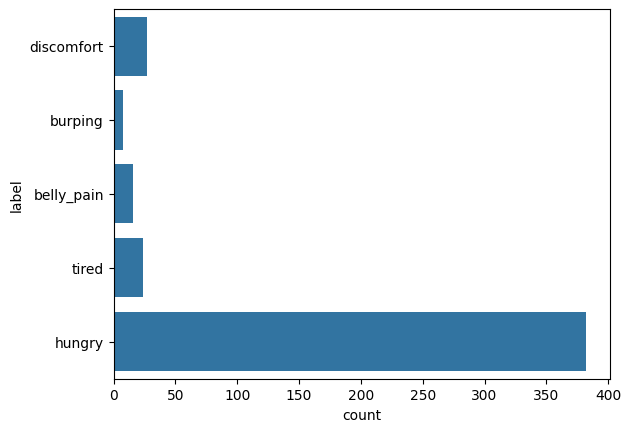

In [101]:
sns.countplot(df['label'])

In [102]:
df_discomfort = df[df['label'] == 'discomfort']
df_burping = df[df['label'] == 'burping']
df_belly_pain = df[df['label'] == 'belly_pain']
df_tired = df[df['label'] == 'tired']

df_hungry = df[df['label'] == 'hungry']

In [103]:
df_hungry.shape

(382, 2)

In [104]:
df_discomfort_resampled = resample(df_discomfort, random_state=42, n_samples=382, replace=True)
df_burping_resampled = resample(df_burping, random_state=42, n_samples=382, replace=True)
df_belly_pain_resampled = resample(df_belly_pain, random_state=42, n_samples=382, replace=True)
df_tired_resampled = resample(df_tired, random_state=42, n_samples=382, replace=True)

In [105]:
df_1 = pd.concat([df_discomfort_resampled, df_burping_resampled])
df_2 = pd.concat([df_belly_pain_resampled, df_tired_resampled])
df_3 = pd.concat([df_1, df_2])

df_upsampled = pd.concat([df_3, df_hungry])

<Axes: xlabel='count', ylabel='label'>

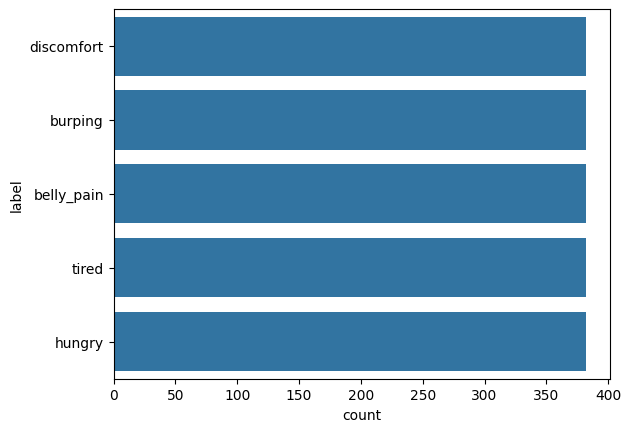

In [106]:
sns.countplot(df_upsampled['label'])

In [107]:
featurestest = df_upsampled['features'].tolist()
labelstest = df_upsampled['label'].tolist()

In [110]:
# convert features and labels to numpy arrays
features = np.array(featurestest)
labels = np.array(labelstest)
# encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

### KNN Model

In [111]:
# train KNN model
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)

KNN Accuracy: 0.9309623430962343


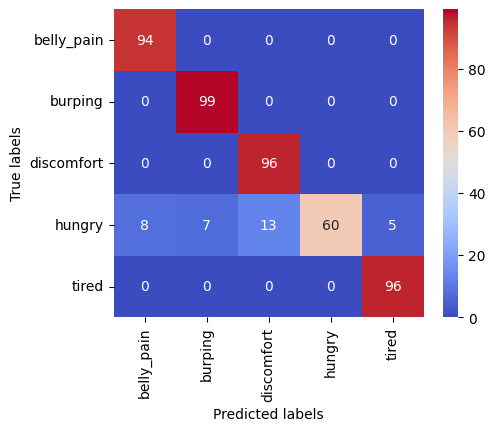

In [112]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

# Compute the confusion matrix
cm = confusion_matrix(y_test, knn_pred)

# Define the label names
label_names = ['belly_pain','burping','discomfort','hungry','tired'] # Add your label names here

# Plot the confusion matrix with a colormap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Assuming the KNN model and predictions are already defined as per your code

# Calculate accuracy
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)

# Calculate precision
knn_precision = precision_score(y_test, knn_pred, average='macro')
print("KNN Precision:", knn_precision)

# Calculate recall
knn_recall = recall_score(y_test, knn_pred, average='macro')
print("KNN Recall:", knn_recall)

# Calculate F1 score
knn_f1 = f1_score(y_test, knn_pred, average='macro')
print("KNN F1 Score:", knn_f1)

# Generate classification report
classification_report = classification_report(y_test, knn_pred)
print("Classification Report:\n", classification_report)

KNN Accuracy: 0.9309623430962343
KNN Precision: 0.9373519772122005
KNN Recall: 0.9290322580645161
KNN F1 Score: 0.9241111425379858
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        94
           1       0.93      1.00      0.97        99
           2       0.88      1.00      0.94        96
           3       1.00      0.65      0.78        93
           4       0.95      1.00      0.97        96

    accuracy                           0.93       478
   macro avg       0.94      0.93      0.92       478
weighted avg       0.94      0.93      0.93       478



In [136]:
test_features = extract_features('/home/pi/CryClassification/dataset/belly_pain/test.wav')
df_test = pd.DataFrame(test_features).transpose()

In [137]:
prediction = knn.predict(df_test)

In [138]:
prediction

array([0])

### Random Forest Model

In [139]:
# train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 1.0


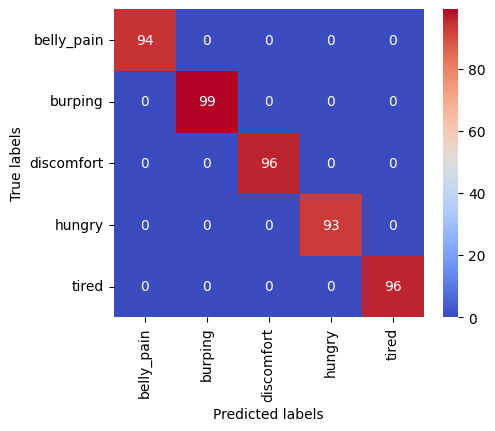

In [140]:
cm = confusion_matrix(y_test, rf_pred)
# Plot the confusion matrix with a colormap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [141]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)

# Calculate precision
rf_precision = precision_score(y_test, rf_pred, average='macro')
print("Random Forest Precision:", rf_precision)

# Calculate recall
rf_recall = recall_score(y_test, rf_pred, average='macro')
print("Random Forest Recall:", rf_recall)

# Calculate F1 score
rf_f1 = f1_score(y_test, rf_pred, average='macro')
print("Random Forest F1 Score:", rf_f1)

# Generate classification report
classification_report = classification_report(y_test, knn_pred)
print("Classification Report:\n", classification_report)

Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        94
           1       0.93      1.00      0.97        99
           2       0.88      1.00      0.94        96
           3       1.00      0.65      0.78        93
           4       0.95      1.00      0.97        96

    accuracy                           0.93       478
   macro avg       0.94      0.93      0.92       478
weighted avg       0.94      0.93      0.93       478



### SVM Model

In [142]:
# train SVM model
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)

SVM Accuracy: 0.9205020920502092


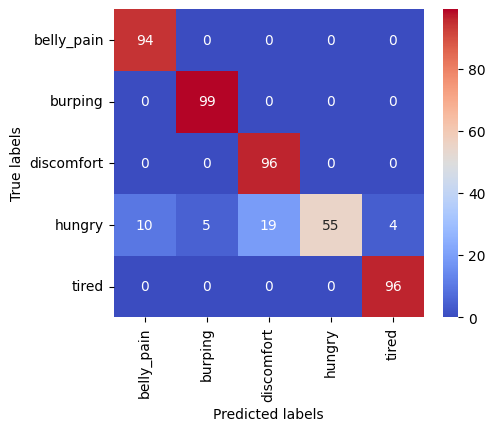

In [143]:
cm = confusion_matrix(y_test, svm_pred)

# Define the label names
label_names = ['belly_pain','burping','discomfort','hungry','tired'] # Add your label names here

# Plot the confusion matrix with a colormap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate accuracy
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_acc)

# Calculate precision
svm_precision = precision_score(y_test, svm_pred, average='macro')
print("SVM Precision:", svm_precision)

# Calculate recall
svm_recall = recall_score(y_test, svm_pred, average='macro')
print("SVM Recall:", svm_recall)

# Calculate F1 score
svm_f1 = f1_score(y_test, svm_pred, average='macro')
print("SVM F1 Score:", svm_f1)

# Generate classification report
classification_report_result = classification_report(y_test, svm_pred)
print("Classification Report:\n", classification_report_result)

SVM Accuracy: 0.9205020920502092
SVM Precision: 0.9301103678929767
SVM Recall: 0.9182795698924732
SVM F1 Score: 0.9115304188472073
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        94
           1       0.95      1.00      0.98        99
           2       0.83      1.00      0.91        96
           3       1.00      0.59      0.74        93
           4       0.96      1.00      0.98        96

    accuracy                           0.92       478
   macro avg       0.93      0.92      0.91       478
weighted avg       0.93      0.92      0.91       478



### Decision Tree Model

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier()

# Train the model using the training sets
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
dts_pred = clf.predict(X_test)

# Print model accuracy
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
      .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.96


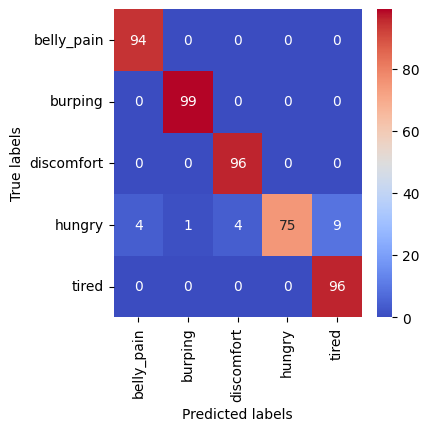

In [146]:
cm = confusion_matrix(y_test, dts_pred)

# Plot the confusion matrix with a colormap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [147]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# Calculate accuracy
accuracy = accuracy_score(y_test, dts_pred)
print('Accuracy:', accuracy)

# Calculate precision
precision = precision_score(y_test, dts_pred, average='macro')
print('Precision:', precision)

# Calculate recall
recall = recall_score(y_test, dts_pred, average='macro')
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(y_test, dts_pred, average='macro')
print('F1 Score:', f1)

# Generate classification report
classification_report_result = classification_report(y_test, dts_pred)
print('Classification Report:\n', classification_report_result)

Accuracy: 0.9623430962343096
Precision: 0.9646938775510204
Recall: 0.9612903225806452
F1 Score: 0.9603628802454753
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        94
           1       0.99      1.00      0.99        99
           2       0.96      1.00      0.98        96
           3       1.00      0.81      0.89        93
           4       0.91      1.00      0.96        96

    accuracy                           0.96       478
   macro avg       0.96      0.96      0.96       478
weighted avg       0.96      0.96      0.96       478



### XG Boost Model

In [149]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define XGBoost classifier with default hyperparameters
xgb_clf = xgb.XGBClassifier()

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# Predict labels on test data
xgb_pred = xgb_clf.predict(X_test)

# Compute accuracy score
acc = accuracy_score(y_test, xgb_pred)
print("XGBoost accuracy:", acc)


XGBoost accuracy: 0.9895397489539749


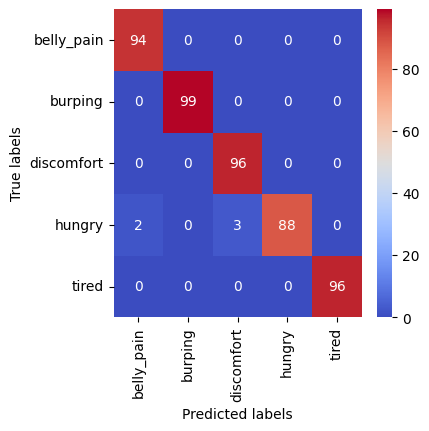

In [150]:
cm = confusion_matrix(y_test, xgb_pred)
# Plot the confusion matrix with a colormap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names,fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, xgb_pred)
print('Accuracy:', accuracy)

# Calculate precision
precision = precision_score(y_test, xgb_pred, average='macro')
print('Precision:', precision)

# Calculate recall
recall = recall_score(y_test, xgb_pred, average='macro')
print('Recall:', recall)

# Calculate F1 score
f1 = f1_score(y_test, xgb_pred, average='macro')
print('F1 Score:', f1)

# Generate classification report
classification_report_result = classification_report(y_test, xgb_pred)
print('Classification Report:\n', classification_report_result)


Accuracy: 0.9895397489539749
Precision: 0.9897727272727274
Recall: 0.989247311827957
F1 Score: 0.989292951886729
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        94
           1       1.00      1.00      1.00        99
           2       0.97      1.00      0.98        96
           3       1.00      0.95      0.97        93
           4       1.00      1.00      1.00        96

    accuracy                           0.99       478
   macro avg       0.99      0.99      0.99       478
weighted avg       0.99      0.99      0.99       478

